Notes
---------

Automated Day Trading Algorithm
Rendition of M1, alternative robo-adivising mechanisms. 

Use historical data to backtest algorithm and use as calibrating process in order to achieve optimal parametric setups and concepts. Look into what proposes a particular choice in parameter and question whether that thought process can be further automated.

Simple concept: 
1. Take 100%, broken into ~20% for buys and ~80% sells.
2. Rank current holdings by most gains/losses. 
3. Based on characteristics of gains/losses:
    1. Use the “buy” funds to purchase holdings with the greatest losses.
    2. Sell the holdings with the greatest gains. *Depending on certain criteria met. 
4. Repeat daily.

Complex concept: 
1. Use valuations, market data, historical trends, and indicators to evaluate purchase/sale actions. 

Machine Learning
------
Y_train, X_train is from previously recorded and scored data (ranked, see "Pickle Storage" below). Scoring is the result of taking the percent growth of (1-live data/previous data). Y_test is the decision t be made against live data. Each 24hr transaction history block is input training data for live test. 


# Config file
Separate file so you can keep your credentials private.

In [ ]:
#Config.py

#Enter your robinhood username and password here, then save this file in the same directory as a regular python file
rh_password="password"
rh_username="username/email"


#TD Ameritrade API
client_id="XXXXXXXXXXXXXXXXXXXXXXXXX"


#Nomics API
#https://api.nomics.com/

nomics_key = "xxxxxxxxxxxxxxxxxxxxxxx"
nomics_email = "email adress"

# change to false to run frfr
debug=True

# set to show plot; if set to false plot will not show
plot=True

# Imports

In [1]:
from config import rh_username,rh_password,nomics_key

import matplotlib.pyplot as plt
from datetime import datetime
import robin_stocks as r
import pandas as pd
import numpy as np
import time
import json
import requests

# Robinhood login

In [2]:
#Robinhood login
login = r.authentication.login(username=rh_username, 
                                  password=rh_password, 
                                  #expiresIn=86400, 
                                  #scope='internal', 
                                  #by_sms=True, 
                                  store_session=True, 
                                  #mfa_code=None
                               )
access_token=login['access_token']
token_type=login['token_type']

In [3]:
#Crypto functions for reference.
"""Contains functions to get information about crypto-currencies."""
import robin_stocks.helper as helper
import robin_stocks.urls as urls

@helper.login_required
def load_crypto_profile(info=None):
    """Gets the information associated with the crypto account.
    :param info: The name of the key whose value is to be returned from the function.
    :type info: Optional[str]
    :returns: [dict] The function returns a dictionary of key/value pairs. \
    If a string is passed in to the info parameter, then the function will return \
    a string corresponding to the value of the key whose name matches the info parameter.
    :Dictionary Keys: * apex_account_number
                      * created_at
                      * id
                      * rhs_account_number
                      * status
                      * status_reason_code
                      * updated_at
                      * user_id
    """
    url = urls.crypto_account()
    data = helper.request_get(url, 'indexzero')
    return(helper.filter_data(data, info))


@helper.login_required
def get_crypto_positions(info=None):
    """Returns crypto positions for the account.
    :param info: Will filter the results to get a specific value.
    :type info: Optional[str]
    :returns: [list] Returns a list of dictionaries of key/value pairs for each option. If info parameter is provided, \
    a list of strings is returned where the strings are the value of the key that matches info.
    :Dictionary Keys: * account_id
                      * cost_basis
                      * created_at
                      * currency
                      * id
                      * quantity
                      * quantity_available
                      * quantity_held_for_buy
                      * quantity_held_for_sell
                      * updated_at
    """
    url = urls.crypto_holdings()
    data = helper.request_get(url, 'pagination')
    return(helper.filter_data(data, info))


def get_crypto_currency_pairs(info=None):
    """Gets a list of all the cypto currencies that you can trade.
    :param info: Will filter the results to have a list of the values that correspond to key that matches info.
    :type info: Optional[str]
    :returns: [list] If info parameter is left as None then the list will contain a dictionary of key/value pairs for each ticker. \
    Otherwise, it will be a list of strings where the strings are the values of the key that corresponds to info.
    :Dictionary Keys: * asset_currency
                      * display_only
                      * id
                      * max_order_size
                      * min_order_size
                      * min_order_price_increment
                      * min_order_quantity_increment
                      * name
                      * quote_currency
                      * symbol
                      * tradability
    """
    url = urls.crypto_currency_pairs()
    data = helper.request_get(url, 'results')
    return(helper.filter_data(data, info))


def get_crypto_info(symbol, info=None):
    """Gets information about a crpyto currency.
    :param symbol: The crypto ticker.
    :type symbol: str
    :param info: Will filter the results to have a list of the values that correspond to key that matches info.
    :type info: Optional[str]
    :returns: [dict] If info parameter is left as None then will return a dictionary of key/value pairs for each ticker. \
    Otherwise, it will be a strings representing the value of the key.
    :Dictionary Keys: * asset_currency
                      * display_only
                      * id
                      * max_order_size
                      * min_order_size
                      * min_order_price_increment
                      * min_order_quantity_increment
                      * name
                      * quote_currency
                      * symbol
                      * tradability
    """
    url = urls.crypto_currency_pairs()
    data = helper.request_get(url, 'results')
    data = [x for x in data if x['asset_currency']['code'] == symbol]
    if len(data) > 0:
        data = data[0]
    else:
        data = None
    return(helper.filter_data(data, info))


@helper.login_required
def get_crypto_quote(symbol, info=None):
    """Gets information about a crypto including low price, high price, and open price
    :param symbol: The crypto ticker.
    :type symbol: str
    :param info: Will filter the results to have a list of the values that correspond to key that matches info.
    :type info: Optional[str]
    :returns: [dict] If info parameter is left as None then the list will contain a dictionary of key/value pairs for each ticker. \
    Otherwise, it will be a list of strings where the strings are the values of the key that corresponds to info.
    :Dictionary Keys: * ask_price
                      * bid_price
                      * high_price
                      * id
                      * low_price
                      * mark_price
                      * open_price
                      * symbol
                      * volume
 
    """
    id = get_crypto_info(symbol, info='id')
    url = urls.crypto_quote(id)
    data = helper.request_get(url)
    return(helper.filter_data(data, info))


@helper.login_required
def get_crypto_quote_from_id(id, info=None):
    """Gets information about a crypto including low price, high price, and open price. Uses the id instead of crypto ticker.
    :param id: The id of a crypto.
    :type id: str
    :param info: Will filter the results to have a list of the values that correspond to key that matches info.
    :type info: Optional[str]
    :returns: [dict] If info parameter is left as None then the list will contain a dictionary of key/value pairs for each ticker. \
    Otherwise, it will be a list of strings where the strings are the values of the key that corresponds to info.
    :Dictionary Keys: * ask_price
                      * bid_price
                      * high_price
                      * id
                      * low_price
                      * mark_price
                      * open_price
                      * symbol
                      * volume
    """
    url = urls.crypto_quote(id)
    data = helper.request_get(url)
    return(helper.filter_data(data, info))


@helper.login_required
def get_crypto_historicals(symbol, interval='hour', span='week', bounds='24_7', info=None):
    """Gets historical information about a crypto including open price, close price, high price, and low price.
    :param symbol: The crypto ticker.
    :type symbol: str
    :param interval: The time between data points. Can be '15second', '5minute', '10minute', 'hour', 'day', or 'week'. Default is 'hour'.
    :type interval: str
    :param span: The entire time frame to collect data points. Can be 'hour', 'day', 'week', 'month', '3month', 'year', or '5year'. Default is 'week'
    :type span: str
    :param bound: The times of day to collect data points. 'Regular' is 6 hours a day, 'trading' is 9 hours a day, \
    'extended' is 16 hours a day, '24_7' is 24 hours a day. Default is '24_7'
    :type bound: str
    :param info: Will filter the results to have a list of the values that correspond to key that matches info.
    :type info: Optional[str]
    :returns: [list] If info parameter is left as None then the list will contain a dictionary of key/value pairs for each ticker. \
    Otherwise, it will be a list of strings where the strings are the values of the key that corresponds to info.
    :Dictionary Keys: * begins_at
                      * open_price
                      * close_price
                      * high_price
                      * low_price
                      * volume
                      * session
                      * interpolated
                      * symbol
    """
    interval_check = ['15second', '5minute', '10minute', 'hour', 'day', 'week']
    span_check = ['hour', 'day', 'week', 'month', '3month', 'year', '5year']
    bounds_check = ['24_7', 'extended', 'regular', 'trading']

    if interval not in interval_check:
        print(
            'ERROR: Interval must be "15second","5minute","10minute","hour","day",or "week"', file=helper.get_output())
        return([None])
    if span not in span_check:
        print('ERROR: Span must be "hour","day","week","month","3month","year",or "5year"', file=helper.get_output())
        return([None])
    if bounds not in bounds_check:
        print('ERROR: Bounds must be "24_7","extended","regular",or "trading"', file=helper.get_output())
        return([None])
    if (bounds == 'extended' or bounds == 'trading') and span != 'day':
        print('ERROR: extended and trading bounds can only be used with a span of "day"', file=helper.get_output())
        return([None])


    symbol = helper.inputs_to_set(symbol)
    id = get_crypto_info(symbol[0], info='id')
    url = urls.crypto_historical(id)
    payload = {'interval': interval,
               'span': span,
               'bounds': bounds}
    data = helper.request_get(url, 'regular', payload)

    histData = []
    cryptoSymbol = data['symbol']
    for subitem in data['data_points']:
        subitem['symbol'] = cryptoSymbol
        histData.append(subitem)

    return(helper.filter_data(histData, info))

In [4]:
my_crypto_data = r.crypto.get_crypto_positions(info=None)
my_crypto = pd.json_normalize(my_crypto_data, max_level=2)
my_crypto

,account_id,cost_bases,created_at,id,quantity,quantity_available,quantity_held_for_buy,quantity_held_for_sell,updated_at,currency.brand_color,currency.code,currency.id,currency.increment,currency.name,currency.type
0,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-11-21T21:52:06.232614-05:00,ee327fc6-8846-41d8-ad95-ea7d0a31ca08,0.000000000000000000,0.000000000000000000,0.000000000000000000,0.000000000000000000,2020-12-17T13:02:13.383366-05:00,,BSV,4a7924c8-d554-47d6-8595-c4e522b0183a,0.000000010000000000,Bitcoin SV,cryptocurrency
1,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-09-19T09:12:37.541146-04:00,330304c3-62ab-4f97-ae13-cd0286279e48,0.022285660000000000,0.022285660000000000,0.000000000000000000,0.000000000000000000,2021-01-03T23:35:06.158210-05:00,BEBBBB,LTC,f9432751-b54d-4d84-b573-f06dc390b766,0.000000010000000000,Litecoin,cryptocurrency
2,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-09-19T09:11:40.599449-04:00,e0ef414a-6a0f-4146-b8ed-f793db8064bc,0.000694000000000000,0.000694000000000000,0.000000000000000000,0.000000000000000000,2021-01-03T23:43:29.158721-05:00,707DB5,ETH,c527c04a-394b-4a44-ae07-19b901ca609c,0.000000000000000001,Ethereum,cryptocurrency
3,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-09-19T09:10:41.172382-04:00,4f7f48af-b812-481b-a8a8-d64395898e69,0.000400660000000000,0.000400660000000000,0.000000000000000000,0.000000000000000000,2021-01-03T23:36:44.087867-05:00,99C061,BCH,913a38ed-36f3-45fb-a967-fb6e30d4a7fb,0.000000010000000000,Bitcoin Cash,cryptocurrency
4,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-08-15T22:24:02.960475-04:00,bf3cb040-1352-4a57-a112-555598df26ee,0.000000000000000000,0.000000000000000000,0.000000000000000000,0.000000000000000000,2020-12-17T13:01:42.793095-05:00,,ETC,ee3bcf3e-4ac7-4f0a-b887-4cea2b49ff70,0.000001000000000000,Ethereum Classic,cryptocurrency
5,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-08-14T20:35:58.654014-04:00,d6a635a1-ecca-4e2c-b17b-aa13f8bdc00c,420286.000000000000000000,50286.000000000000000000,0.000000000000000000,370000.000000000000000000,2021-01-08T18:16:29.297166-05:00,BEA649,DOGE,c6996ebc-2f9b-443a-b2c2-7ddf02e0ef3a,1.000000000000000000,Dogecoin,cryptocurrency
6,8d7ec66c-9324-463f-be2c-7dec268b5e05,[{'currency_id': '1072fc76-1862-41ab-82c2-4858...,2020-08-14T20:31:23.420403-04:00,ec221fae-a33f-4960-8937-a0eb4176a26d,0.000046620000000000,0.000046620000000000,0.000000000000000000,0.000000000000000000,2021-01-04T17:04:55.229257-05:00,EA963D,BTC,d674efea-e623-4396-9026-39574b92b093,0.000000010000000000,Bitcoin,cryptocurrency


<AxesSubplot:>

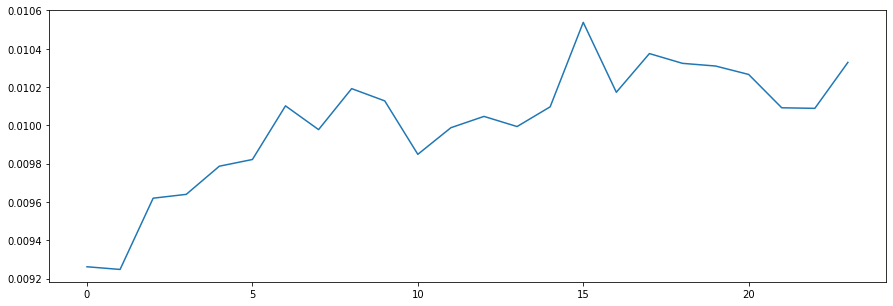

In [7]:
#Doge data
symbol='doge'
crypto_historical=pd.DataFrame.from_dict(r.crypto.get_crypto_historicals(symbol, interval='hour', span='day', bounds='24_7', info=None))
crypto_historical['begins_at']=pd.to_datetime(crypto_historical['begins_at'], format='%Y-%m-%d')

crypto_historical['begins_at'] = crypto_historical.apply(lambda x : pd.Timestamp(x['begins_at'].strftime("%Y-%m-%d")),axis=1)
crypto_historical['close_price'] = crypto_historical.apply(lambda x : float(x['close_price']),axis=1)

crypto_historical['close_price'].plot(figsize=(15,5))

<AxesSubplot:>

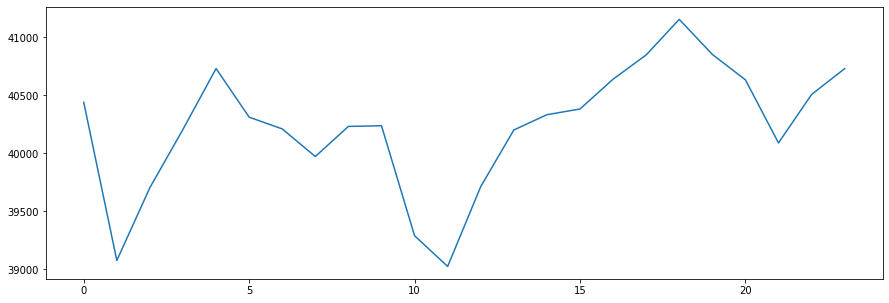

In [8]:
#Bitcoin data
symbol='btc'
crypto_historical=pd.DataFrame.from_dict(r.crypto.get_crypto_historicals(symbol, interval='hour', span='day', bounds='24_7', info=None))
crypto_historical['begins_at']=pd.to_datetime(crypto_historical['begins_at'], format='%Y-%m-%d')

crypto_historical['begins_at'] = crypto_historical.apply(lambda x : pd.Timestamp(x['begins_at'].strftime("%Y-%m-%d")),axis=1)
crypto_historical['close_price'] = crypto_historical.apply(lambda x : float(x['close_price']),axis=1)

crypto_historical['close_price'].plot(figsize=(15,5))

In [ ]:
import time

def executeSomething():
#code here
    print("Execution complete. Time: ",datetime.now())
    time.sleep(5)
 
while True:
    executeSomething()

Buy & sell crypto orders
-----

In [ ]:
#Sell half a Bitcoin is price reaches 10,000
>>> r.order_sell_crypto_limit('BTC',0.5,10000)

#Buy  500 worth of Bitcoin
>>> r.order_buy_crypto_by_price('BTC',500)

# Indicators

What Is the Relative Strength Index (RSI)?
-------------
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. The indicator was originally developed by J. Welles Wilder Jr. and introduced in his seminal 1978 book, "New Concepts in Technical Trading Systems."


Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

RSI Swing Rejections
-------------
Another trading technique examines the RSI's behavior when it is reemerging from overbought or oversold territory. This signal is called a bullish "swing rejection" and has four parts:

RSI falls into oversold territory.
RSI crosses back above 30%.
RSI forms another dip without crossing back into oversold territory.
RSI then breaks its most recent high.

The relative strength index is a momentum oscillator commonly used to predict when a company is oversold or overbought. The calculation process is straightforward:
Observe the last 14 closing prices of a stock.
Determine whether the current day’s closing price is higher or lower than the previous day.
Calculate the average gain and loss over the last 14 days.
Compute the relative strength (RS): (AvgGain/AvgLoss)
Compute the relative strength index (RSI): (100–100 / ( 1 + RS))
The RSI will then be a value between 0 and 100. It is widely accepted that when the RSI is 30 or below, the stock is undervalued and when it is 70 or above, the stock is overvalued.

In [10]:
import pandas_datareader.data as web

#Retrieve DOGE & BTC data
symbol='DOGE'
crypto_historical=pd.DataFrame.from_dict(r.crypto.get_crypto_historicals(symbol, interval='hour', span='day', bounds='24_7', info=None))
crypto_historical['begins_at']=pd.to_datetime(crypto_historical['begins_at'], format="%Y-%m-%dT%H:%M:%fZ")

crypto_historical['begins_at'] = crypto_historical.apply(lambda x : pd.Timestamp(x['begins_at'],),axis=1)
crypto_historical['close_price'] = crypto_historical.apply(lambda x : float(x['close_price']),axis=1)
doge=crypto_historical.drop(columns=['volume','session','interpolated','symbol'])

symbol='BTC'
crypto_historical=pd.DataFrame.from_dict(r.crypto.get_crypto_historicals(symbol, interval='hour', span='day', bounds='24_7', info=None))
crypto_historical['begins_at']=pd.to_datetime(crypto_historical['begins_at'], format="%Y-%m-%dT%H:%M:%fZ")

crypto_historical['begins_at'] = crypto_historical.apply(lambda x : pd.Timestamp(x['begins_at'],),axis=1)
crypto_historical['close_price'] = crypto_historical.apply(lambda x : float(x['close_price']),axis=1)
btc=crypto_historical.drop(columns=['volume','session','interpolated','symbol'])

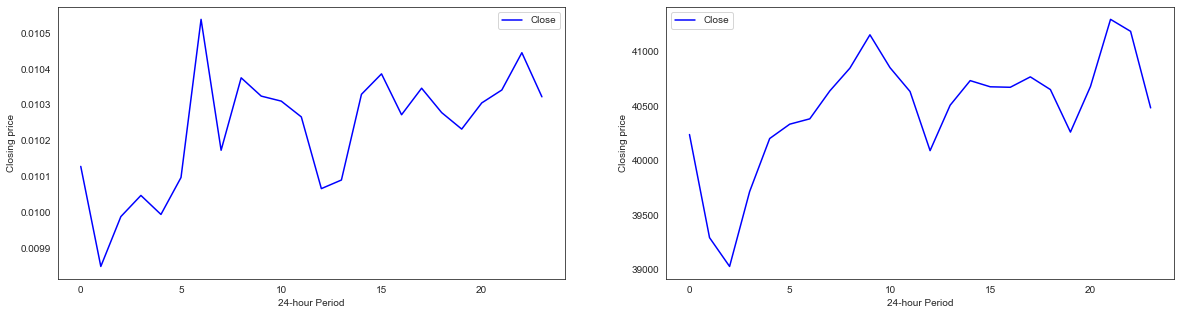

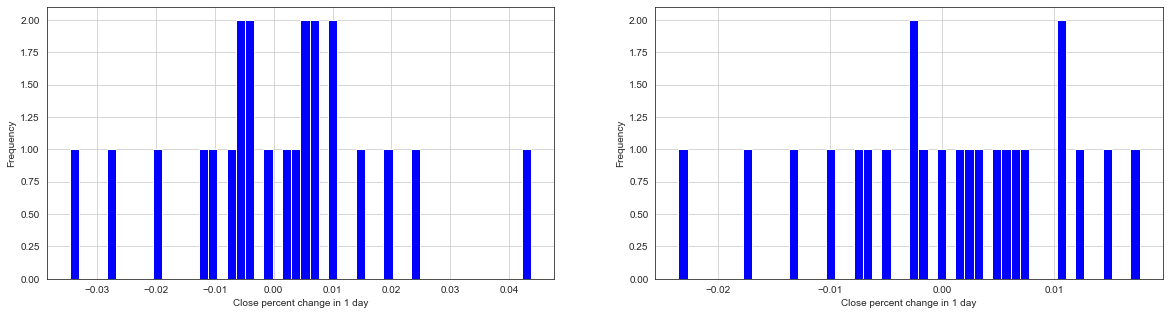

In [11]:
#PReliminary plots
import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

df_list = [doge,btc]

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
for index, ax in enumerate(ax):    
    df_list[index]['close_price'].plot(label='Close', color='b', legend=True, ax=ax)
    ax.set_xlabel('24-hour Period')
    ax.set_ylabel('Closing price')

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
for index, ax in enumerate(ax): 
    df_list[index]['close_price'].pct_change().hist(bins=50, color = 'b', ax=ax)
    ax.set_xlabel('Close percent change in 1 day')
    ax.set_ylabel('Frequency')

<AxesSubplot:>

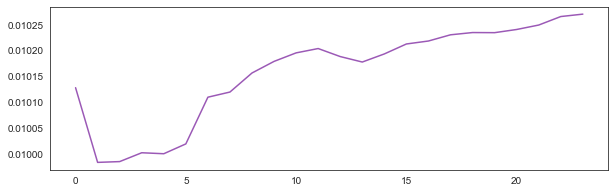

In [12]:
#Simple 14-day moving average for doge
doge['close_price'].ewm(14).mean().plot(figsize=(10,3))

<AxesSubplot:>

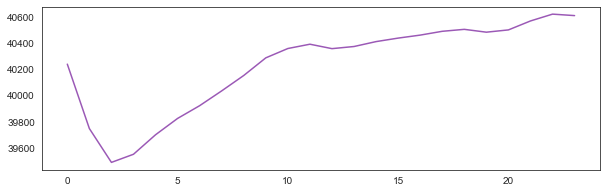

In [13]:
#Simple 14-day moving average for btc
btc['close_price'].ewm(14).mean().plot(figsize=(10,3))

Unfortunately, the EWMA and RSI functions still need work for accuracy. This section can be further worked on.

In [14]:
def EWMA(stock_list, days_list, name_list):
    from itertools import cycle
    color = cycale('grc')

    for index,stock in enumerate(stock_list):
        fig, ax = plt.subplots(figsize=(20,6))
        stock['close_price'].plot(title = name_list[index], label= 'close_price', color='b', legend=True, ax=ax)    
        for day in days_list:    
            stock['close_price'].ewm(com=day/24).mean().plot(label= 'ewma_' + str(day) + 'hour', color= next(color), legend=True, ax=ax)
            ax.set_xlabel('trading days')
            ax.set_ylabel('price')    

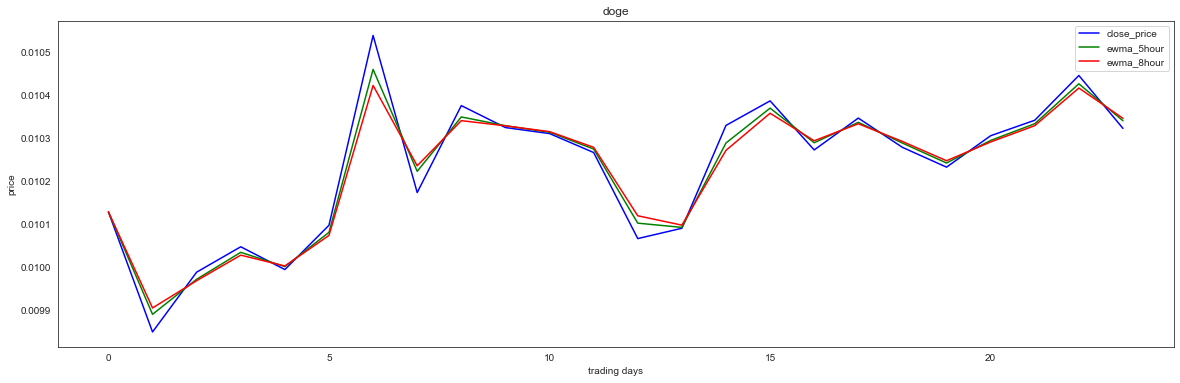

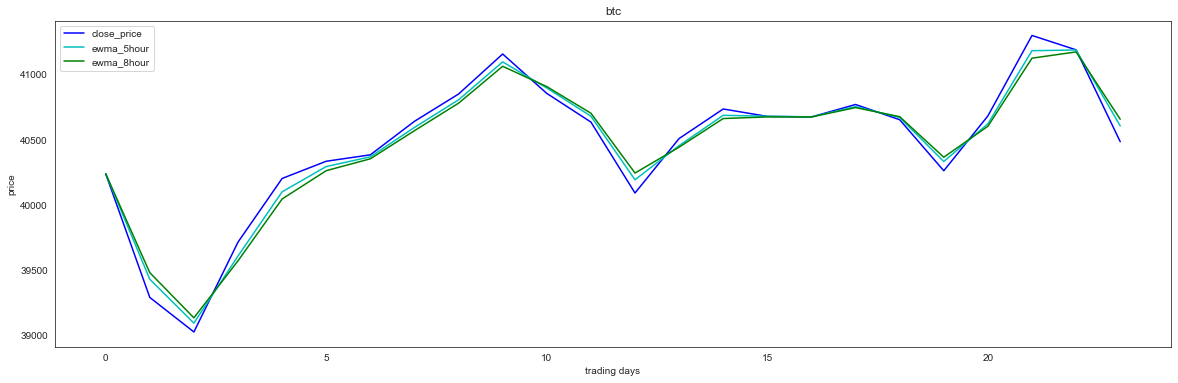

In [15]:
# call the funtion by passing stocks,their names and days ewma required          
EWMA(stock_list = [doge,btc], name_list = ['doge','btc'], days_list = [5,8]) 

In [16]:
def RSI(stock, column="close_price", period=14):
    # Wilder's RSI
    close = stock[column]
    delta = close.diff() 
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0
    
    # Calculate the exponential moving averages (EWMA)
    roll_up = up.ewm(com=period - 1, adjust=False).mean()
    roll_down = down.ewm(com=period - 1, adjust=False).mean().abs()
    
    # Calculate RS based on exponential moving average (EWMA)
    rs = roll_up / roll_down   # relative strength =  average gain/average loss

    rsi = 100-(100/(1+rs))
    stock['RSI'] = rsi
    
    return stock

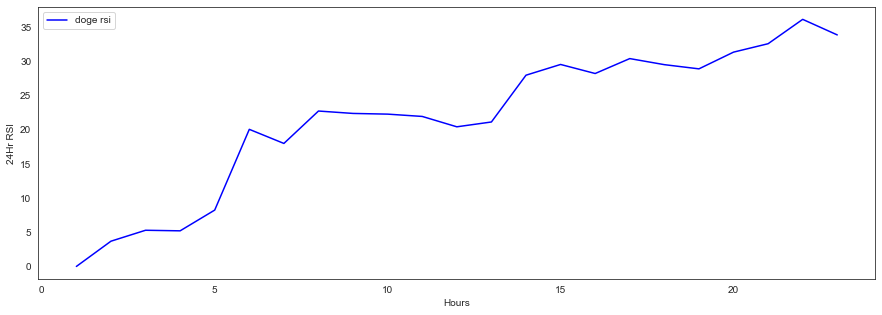

In [17]:
#RSI doge
RSI(doge).head(15)
fig,ax=plt.subplots(figsize=(15,5))
doge.RSI.plot(ax=ax, label='doge rsi', legend=True, color='b');
ax.set_xlabel('Hours'); ax.set_ylabel('24Hr RSI');

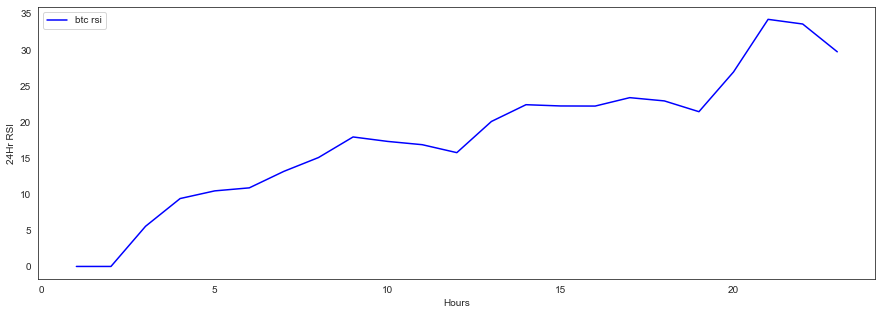

In [18]:
#RSI btc
RSI(btc).head(15)
fig,ax=plt.subplots(figsize=(15,5))
btc.RSI.plot(ax=ax, label='btc rsi', legend=True, color='b');
ax.set_xlabel('Hours'); ax.set_ylabel('24Hr RSI');

RSI trading strategies:
https://tradingsim.com/blog/relative-strength-index/

# Pickle storage

Ideally, the program will append an updated log of transactions, rates of returns, and all historical data. Rank each transactions-window (say per 1hr blocks) by % returns. Use most recently appended data as training/learning dataframes for perpetual validation in future/live data.

In [19]:
#https://opensource.com/article/20/4/python-crypto-trading-bot
import pickle, pathlib, os
import pandas as pd

outout = None

if isinstance(input, pd.DataFrame):
    file_name = 'crypto_doge.bin'
    home_path = str(pathlib.Path.home())
    data_path = os.path.join(home_path, file_name)

    try:
        df = pickle.load(open(data_path, 'rb'))
        n_row_cnt = df.shape[0]
        df = pd.concat([df,input], ignore_index=True).drop_duplicates(['close_time'])
        df.reset_index(drop=True, inplace=True)
        n_new_rows = df.shape[0] - n_row_cnt
        log_txt = '{}: {} new rows written'.format(file_name, n_new_rows)
    except:
        log_txt = 'File error - writing new one: {}'.format(e)
        df = input

    pickle.dump(df, open(data_path, "wb" ))
    output = df